### can run this one by one interactively or, as a batch, run `../scripts/general_postproc.py`

In [1]:
import sys
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
sys.path.insert(0,'../scripts/')
from postprocessing import setup_postproc, check_pdc, plot_phi, get_obs_and_noise, get_pars, plot_group, plot_pars_group

/Users/mnfienen/Documents/GIT/hytest/NHM_CAL/nhm_pestpp/notebooks/../dependencies/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [21]:
# curr_model = '01473000'
# curr_model = '05431486'
curr_model = '09112500'
curr_run_root = 'ies_hot'
# curr_run_root = 'prior_mc_reweight'
eval_pdc = False
unzip_dirs = True
phi_cutoffs = {cm:{crr:9e99 for crr in ['ies','prior_mc_reweight']}
                for cm in ['01473000','05431486', '09112500']}
pstdir, results_file, tmp_res_path, fig_dir, obs, pst = setup_postproc(curr_model, curr_run_root, unzip_dirs)

error parsing metadata from 'obsnme', continuing


### check out PDC

In [22]:
pst.nnz_obs_groups

['g_min_actet_mean_mon',
 'g_min_actet_mon',
 'g_min_recharge_ann',
 'g_min_runoff_mon',
 'g_min_sca_daily',
 'g_min_soil_moist_ann',
 'g_min_soil_moist_mon',
 'l_max_actet_mean_mon',
 'l_max_actet_mon',
 'l_max_recharge_ann',
 'l_max_runoff_mon',
 'l_max_sca_daily',
 'l_max_soil_moist_ann',
 'l_max_soil_moist_mon',
 'streamflow_daily_pulse_asc',
 'streamflow_daily_pulse_dsc',
 'streamflow_daily_low',
 'streamflow_daily_exlow',
 'streamflow_mean_mon',
 'streamflow_mon']

In [23]:
if eval_pdc:
    pdc = check_pdc(tmp_res_path, curr_run_root, pst, obs)
    print(pdc)

### look at PHI history

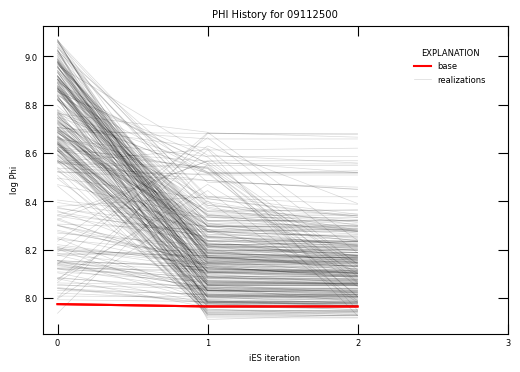

In [24]:
phi = plot_phi(tmp_res_path, curr_run_root, curr_model, fig_dir)

### Truncate PHI at a threshold

In [25]:
phi

,total_runs,mean,standard_deviation,min,max,0,1,2,3,4,...,316,317,318,319,320,321,322,323,324,base
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,542957000.0,296977000.0,86524700.0,1.173720e+09,510065000.0,142824000.0,861443000.0,597632000.0,726612000.0,...,408409000.0,452904000.0,602451000.0,163379000.0,540168000.0,479573000.0,219711000.0,420587000.0,818977000.0,94392500.0
1,476,169335000.0,85772300.0,81467600.0,4.854190e+08,193596000.0,134006000.0,106788000.0,107316000.0,128045000.0,...,96073300.0,98318800.0,241664000.0,139909000.0,208186000.0,230727000.0,368430000.0,92533800.0,NaN,92314100.0
2,938,150056000.0,67639800.0,82720200.0,4.798040e+08,198551000.0,123872000.0,106788000.0,105249000.0,129623000.0,...,92793100.0,95588800.0,218954000.0,139909000.0,193574000.0,231116000.0,138979000.0,92533800.0,NaN,92314100.0


In [26]:
best_iter = 2
if 'prior' in curr_run_root:
    best_iter = 0
best_iter

2

## now rejection sampling for outlier PHI values

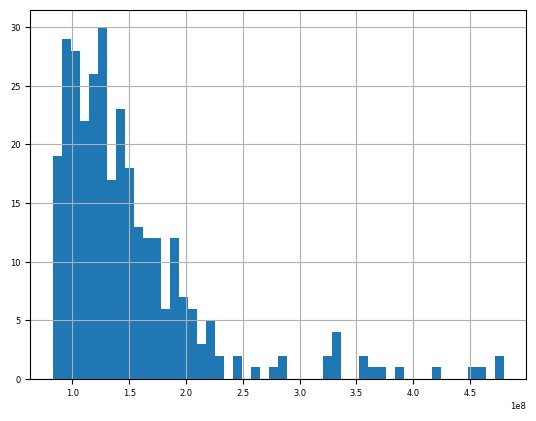

In [27]:
orgphi = phi.loc[best_iter].iloc[5:].copy()
ax = orgphi.hist(bins=50)
lims = ax.get_xlim()

In [28]:
# catalog of cutoffs heuristically determined
phi_cutoffs['01473000']['prior_mc_reweight'] = .6e10
phi_cutoffs['01473000']['ies_hot'] = 2.5e7
phi_cutoffs['05431486']['prior_mc_reweight'] = 2.2e9
phi_cutoffs['05431486']['ies_hot'] = 1.4e8
phi_cutoffs['09112500']['prior_mc_reweight'] = 3.0e9
phi_cutoffs['09112500']['ies_hot'] = 1.8e8

In [29]:
phi_too_high = phi_cutoffs[curr_model][curr_run_root]
phi_too_high

180000000.0

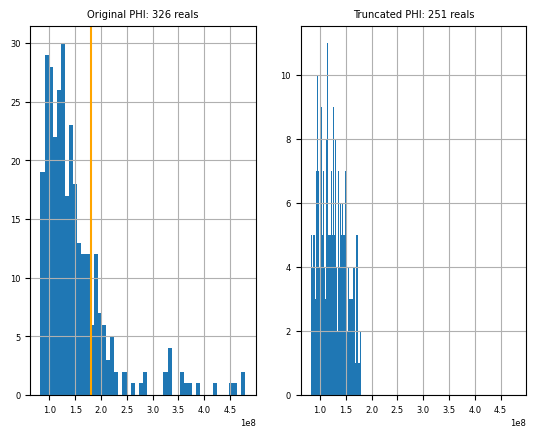

In [30]:
phi = orgphi.loc[orgphi<=phi_too_high]
fig,ax = plt.subplots(1,2)
### --> need to indicate which reals we will carry forward <-- ###
orgphi.hist(bins=50, ax=ax[0])
reals = phi.index 
phi.hist(bins=50, ax=ax[1])
ax[0].axvline(phi_too_high, color='orange')
ax[1].set_xlim(lims)
ax[0].set_title(f'Original PHI: {len(orgphi)} reals')
ax[1].set_title(f'Truncated PHI: {len(phi)} reals')
plt.savefig(fig_dir/ 'phi_histogram.pdf')


# How about parameters?

In [ ]:
parens = get_pars(tmp_res_path, curr_run_root, reals, best_iter, pst)


In [ ]:
pargps = parens['pargroup'].unique()
pargps


In [ ]:
for cg in pargps:
    plot_pars_group(parens, cg, fig_dir, curr_model, best_iter, curr_run_root)

# Now let's start looking at the fits

In [ ]:
modens, obens_noise = get_obs_and_noise(tmp_res_path, curr_run_root, reals, best_iter)

In [ ]:
modens

In [ ]:
import numpy as np
modens.quantile([0.05,0.95])

In [ ]:
obens_noise

In [ ]:
pst.obs_groups

In [ ]:
# plot_group('sca_daily', obs, modens, obens_noise, fig_dir, curr_model)

In [ ]:
plot_group('actet_mean_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('actet_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('runoff_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('soil_moist_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('recharge_ann', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)

# streamflow_daily is a special case - all aggregated
plot_group('streamflow_daily', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('streamflow_mean_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('streamflow_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
